In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [00:32<00:00, 215MB/s]
100% 5.76G/5.76G [00:33<00:00, 187MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [7]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/train_images'
valid_path = '/content/test_images'

In [8]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [10]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Defining the working directories

# work_dir = '/content/cassava-leaf-disease-classification.zip'
# os.listdir(work_dir)
train_path = '/content/train_images'

In [11]:
#%% IMPORTING DATA

# Importing train.csv

data = pd.read_csv('train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [12]:
# Importing the json file with labels

f = open(  'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)
print(data.head(10))
print(data['class_name'].unique())

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
5  1000837476.jpg      3         Cassava Mosaic Disease (CMD)
6  1000910826.jpg      2           Cassava Green Mottle (CGM)
7  1001320321.jpg      0       Cassava Bacterial Blight (CBB)
8  1001723730.jpg      4                              Healthy
9  1001742395.jpg      3         Cassava Mosaic Disease (CMD)
['Cassava Bacterial Blight (CBB)' 'Cassava Mosaic Disease (CMD)'
 'Cassava Brown Streak Disease (CBSD)' 'Cassava Green Mottle (CGM)'
 'Healthy']


In [13]:
def showImages(images):

    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(16)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
    for i in range(16):
        plt.subplot(4,4, i + 1)
        img = plt.imread(train_path+'/'+random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

In [14]:
mask = data['label'] ==4
classHealthy = data[mask]

In [15]:
mask = data['label'] ==3
classCMD = data[mask]

In [16]:
mask = data['label'] ==2
classCGM = data[mask]

In [17]:
mask = data['label'] ==1
classCBSD = data[mask]

In [18]:
mask = data['label'] ==0
classCBB = data[mask]

In [19]:
class0 = classCBB.sample(frac=0.49)
class1 = classCBSD.sample(frac=0.49)
class2 = classCGM.sample(frac=0.49)
class3 = classCMD.sample(frac=0.49)
class4 = classHealthy.sample(frac=0.49)




frames=[class0,class1,class2,class3,class4]
finalData = pd.concat(frames)
finalData.head(10)
print(len(finalData))

10485


In [22]:
# Ensure to define necessary variables and import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define necessary paths
train_path = '/content/train_images'
valid_path = '/content/test_images'

# Load data and define working directories
data = pd.read_csv('/content/train.csv')
f = open('/content/label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}
data['class_name'] = data.label.map(real_labels)

# Define working dataset and split data into train and validation sets
train, val = train_test_split(data, test_size=0.05, random_state=42, stratify=data['class_name'])

# Define image size
IMG_SIZE = (224, 224)

# Define ImageDataGenerator with appropriate preprocessing function and image size
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Use correct target size in flow_from_dataframe
train_set = datagen.flow_from_dataframe(train,
                                        directory=train_path,
                                        seed=42,
                                        x_col='image_id',
                                        y_col='class_name',
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        interpolation='nearest',
                                        shuffle=True,
                                        batch_size=32)

val_set = datagen.flow_from_dataframe(val,
                                      directory=train_path,
                                      seed=42,
                                      x_col='image_id',
                                      y_col='class_name',
                                      target_size=IMG_SIZE,
                                      class_mode='categorical',
                                      interpolation='nearest',
                                      shuffle=True,
                                      batch_size=32)

# Ensure that the model input shape matches the image size
vgg16 = VGG16(input_shape=IMG_SIZE + (3,), weights='imagenet', include_top=False)

# Freeze the pretrained layers
for layer in vgg16.layers:
    layer.trainable = False

# Flatten the output of VGG16
x = Flatten()(vgg16.output)

# Add the output layer
prediction = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=vgg16.input, outputs=prediction)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
# r = model.fit(
#     train_set,
#     validation_data=val_set,
#     epochs=10,
#     steps_per_epoch=len(train_set),
#     validation_steps=len(val_set)
# )


Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


Epoch 1/10
636/636 [==============================] - 447s 702ms/step - loss: 1.1266 - accuracy: 0.6384 - val_loss: 1.1300 - val_accuracy: 0.6570
Epoch 2/10
636/636 [==============================] - 467s 735ms/step - loss: 1.1075 - accuracy: 0.6548 - val_loss: 1.6973 - val_accuracy: 0.6374
Epoch 3/10
636/636 [==============================] - 437s 688ms/step - loss: 1.1075 - accuracy: 0.6641 - val_loss: 1.1164 - val_accuracy: 0.6206
Epoch 4/10
636/636 [==============================] - 445s 699ms/step - loss: 1.1099 - accuracy: 0.6613 - val_loss: 0.9970 - val_accuracy: 0.6832
Epoch 5/10
636/636 [==============================] - 438s 689ms/step - loss: 1.1267 - accuracy: 0.6676 - val_loss: 1.2402 - val_accuracy: 0.6757
Epoch 6/10
636/636 [==============================] - 436s 686ms/step - loss: 1.1192 - accuracy: 0.6666 - val_loss: 1.1805 - val_accuracy: 0.6411
Epoch 7/10
636/636 [==============================] - 434s 683ms/step - loss: 1.1048 - accuracy: 0.6681 - val_loss: 1.1890 -

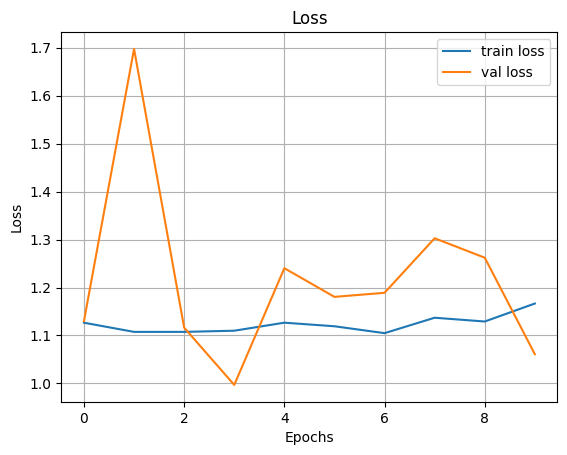

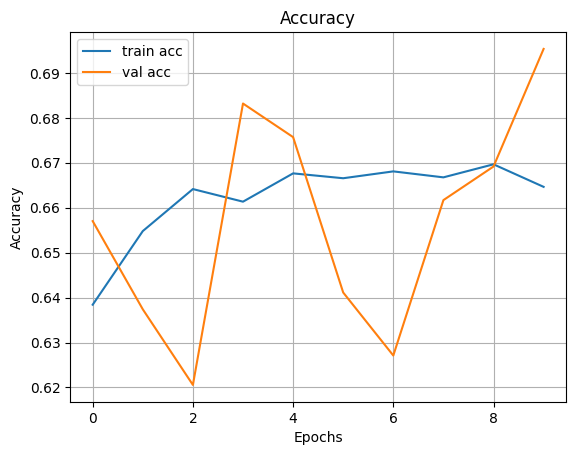

In [23]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    steps_per_epoch=len(train_set),
    validation_steps=len(val_set)
)

# Plot the loss
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.savefig('LossVal_loss.png')  # Save the plot as an image
plt.show()

# Plot the accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.savefig('AccVal_acc.png')  # Save the plot as an image
plt.show()

In [24]:
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

y_pred = model.predict(val_set)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 37s 1s/step


In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 3, 3, ..., 3, 3, 3])

In [33]:
import glob

TEST_DIR = '/content/test_images'
test_images = glob.glob(os.path.join(TEST_DIR, "*.jpg")) + glob.glob(os.path.join(TEST_DIR, "*.png"))
predictions = []
IMG_SIZE = 380
IMG_SIZE1 = 224
size = (IMG_SIZE,IMG_SIZE)
size1= (IMG_SIZE1,IMG_SIZE1)
for image in test_images:
    '''
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    prediction1 = final_model1.predict(img)
    print(prediction1)
    '''
    img1 = Image.open(os.path.join(TEST_DIR, image))
    img1 = img1.resize(size1)
    img1 = np.expand_dims(img1, axis=0)
    prediction2 = model.predict(img1)
    print(prediction2)

    predictions.extend(prediction2.argmax(axis = 1))

1/1 [==============================] - 0s 20ms/step
[[1.0980086e-30 7.9522329e-36 2.5137362e-26 9.4543377e-18 1.0000000e+00]]
1/1 [==============================] - 0s 20ms/step
[[0. 0. 0. 1. 0.]]


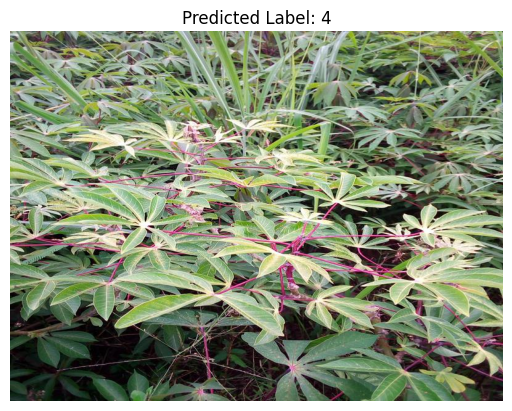

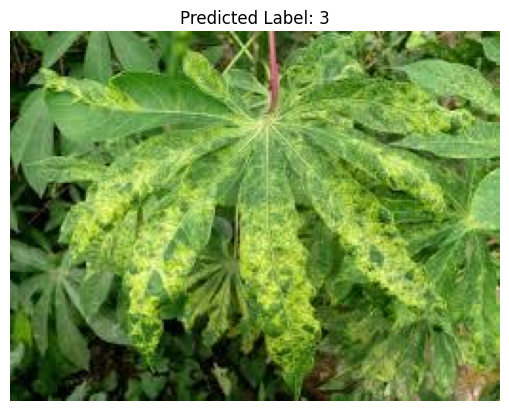

In [34]:
import matplotlib.pyplot as plt


for image_path, prediction in zip(test_images, predictions):

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')


    plt.title(f'Predicted Label: {prediction}')


    plt.show()
